# Notebook for testing the SETP-identification algorithms

In [1]:
from classes import *
#in classes, also tipping will be imported!

import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import random
import ruptures as rpt

from tqdm.notebook import trange, tqdm
from pathlib import Path

from matplotlib import patches
from matplotlib.collections import PatchCollection

In [2]:
#Load the experiments
input_path = "temp/experiments/experiment_selection_2020_11_4.p"
assert Path(input_path).exists()
experiments = pickle.load( open( input_path, "rb" ) )
print(len(experiments))

1400


The overlap in this list can be easily explained; each unique experiment has 4 Metrics!!!

In [4]:
#SET THE PARAMETERS TO DO THE ANALYSIS
window = 4 #The size of the rolling window
margin = 2 # The margin around the TP

#Criteria
c1 = 0.15 #fraction of change relative to house price at t0
c2 = 2e9 #variance
c3 = 10 #percent

In [5]:
#experiments = experiments[0:100]

with tqdm(total=len(experiments)) as pbar:
    for experiment in experiments:
        experiment.create_Metrics() #TODO: GIVE CONTROL OVER THE METRICS TO BE CREATED
        for M in experiment.allMetrics:
            M.create_statistics(window=window) #Create summary statistics for the metric(t)
            M.find_SETP_candidates(c1=c1,c2=c2,c3=c3,margin=margin)
            M.select_SETPs(sign=-1,add_stable_before=True) #Also consider states which are only stable before as policy relevant
        pbar.update(1)
            #M.plot_both(figsize=(15,20),exp_name=experiment.name)

D:\Python\Urban-SETP\tipping.py:210: RuntimeWarning: divide by zero encountered in double_scalars
  perc_diff = 100 * abs(difference / mean_state_before)


D:\Python\Urban-SETP\tipping.py:210: RuntimeWarning: invalid value encountered in double_scalars
  perc_diff = 100 * abs(difference / mean_state_before)


### Visualisations of individual experiments

In [7]:
#todo: move to tipping.py

def add_suptitle(fig,exp,M):
    """Add some information about the experiment as title to the figure
    
    Arguments:
        fig (Matplotlib Figure) : Figure created with M.plot_SETPs
        exp : experiment object from which to draw the metadata
        metric : the metric from which to draw the metadata
        
    Returns:
        fig (Matplotlib Figure) : the input figure with a suptitle
    
    """
    
    #Make the data of the experiment more readable before sending it to the string
    housing_market = M.name.split('_')[-1]
    if housing_market == 'subj':  housing_market = 'Boundedly rational'
    else: housing_market = 'Rational'
    
    area_name = M.name.split('_')[1]
    if area_name == 'A': area_name = 'A (Heijplaat, outer-dike)'
    else: area_name = 'B (City Centre, inner-dike)'
    
    #Create the title string
    suptitle_string = (\
    '''Sea level rise scenario: {} ||| Storm surge series: {} ||| Mayor: {}
    {} housing market ||| Area {}'''.format(
                                   exp.SurgeLevel.corresponding_SLR_Scenario.name.split('_')[-1],
                                   exp.SurgeLevel.corresponding_SurgeHeight.name.split('_')[-1],        
                                   exp.Mayor.get_name(),
                                   housing_market,
                                   area_name))
    fig.suptitle(suptitle_string)
    
    file_string = exp.SurgeLevel.corresponding_SLR_Scenario.name.split('_')[-1] + '_' +\
                  exp.SurgeLevel.corresponding_SurgeHeight.name.split('_')[-1] + '_' + \
                  exp.Mayor.get_name() + '_' + M.name.split('_')[-1] + '_' + M.name.split('_')[1]
    return fig,file_string
    

In [10]:
#CREATE SUBFOLDER IN VISUALISATION WITH CURRENT DATE
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
target = Path('Visualisations',date,'21_TP_identification')
if not Path.exists(target): target.mkdir()
else: print("Target folder {} already exists".format(target))

Target folder Visualisations\2021_2_15\21_TP_identification already exists


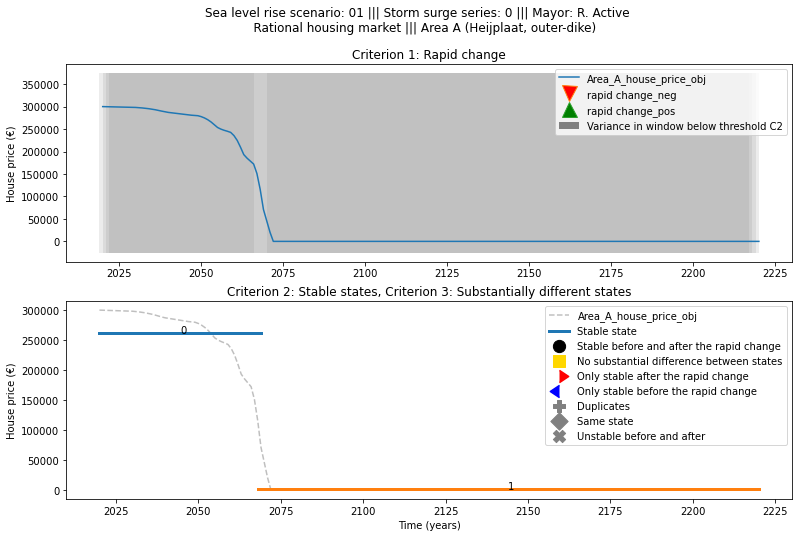

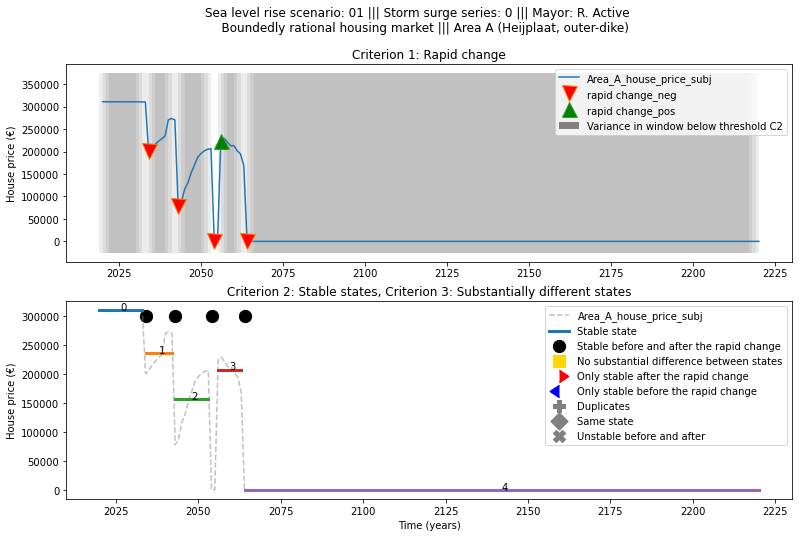

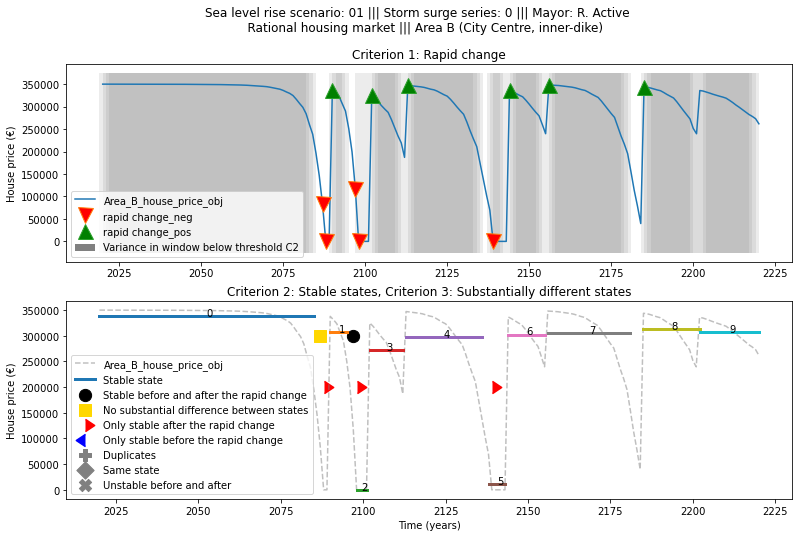

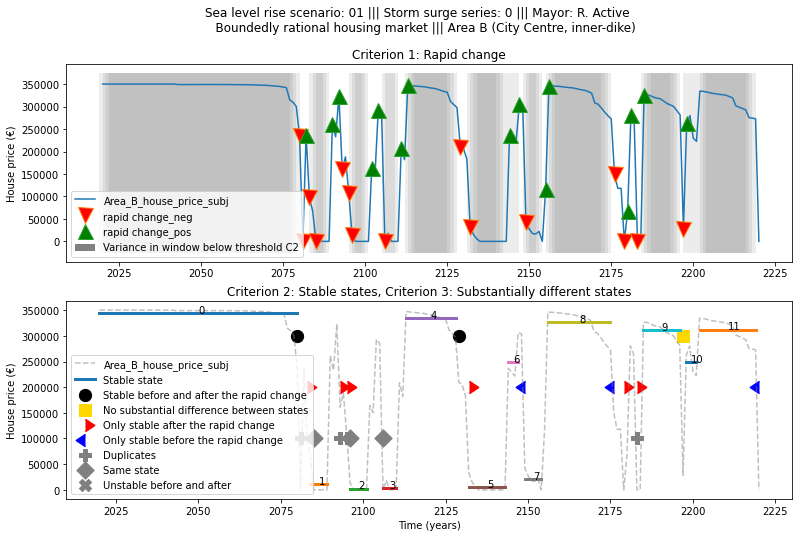

In [12]:
#Todo: show the details of the experiment in addition to the plot
exp = experiments[0]

for M in exp.allMetrics:
    fig, ax = M.plot_SETPs(figsize=(13,8))
    fig, file_string = add_suptitle(fig,exp,M)
    filename = file_string.replace(" ", "")
    fig.savefig(Path(target, (filename + ".png")),bbox_inches='tight',dpi=150)
    
    del fig, ax

In [13]:
import tqdm

KeyboardInterrupt: 

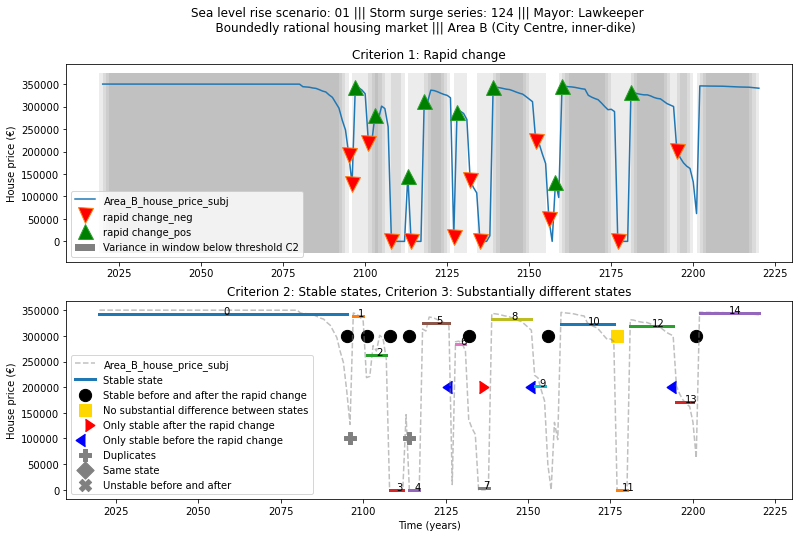

In [15]:
for exp in tqdm.notebook.tqdm(experiments):
    for M in exp.allMetrics:
        fig, ax = M.plot_SETPs(figsize=(13,8))
        fig, file_string = add_suptitle(fig,exp,M)
        filename = file_string.replace(" ", "")
        fig.savefig(Path(target, (filename + ".png")),bbox_inches='tight',dpi=150)
        plt.close(fig)
        del fig, ax

### Select an interesting metric to improve the signal analysis

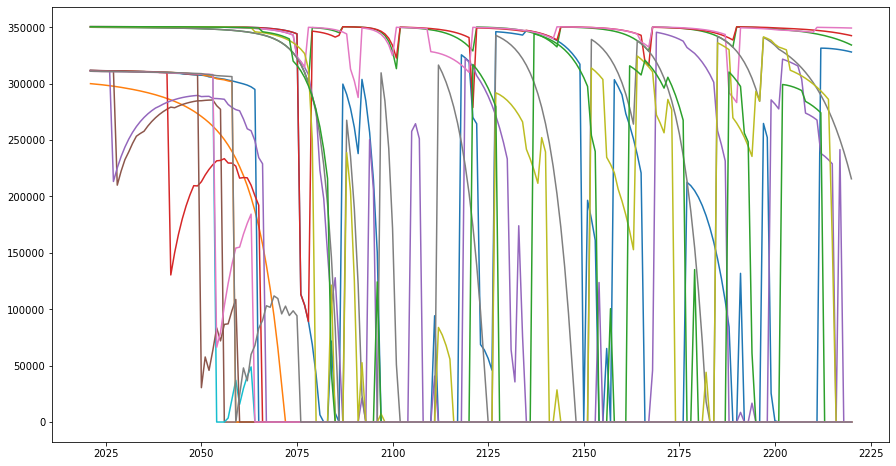

In [6]:
#Select some experiments with interesting signals
sel_experiments = sel_exp(experiments,['01','02'],'All',['R. Active','Sentiment'])

#Intereting shapes
A0_r = [1,69] #area 0 rational
A0_br = [3,5,7,9,11,15,19,45,49,59] # area 0 boundedly rational
A1_r = [1,4]
A1_br = [0,1,2,3,4,10]

M_sel = [] #List Pd Series containing interesting metrics

for i,exp in enumerate(sel_experiments):
    if i in A0_r:
        M_sel.append(exp.allMetrics[0])
    if i in A0_br:
        M_sel.append(exp.allMetrics[1])
    if i in A1_r:
        M_sel.append(exp.allMetrics[2])
    if i in A1_br:
        M_sel.append(exp.allMetrics[3])

M_sel

fig, ax = plt.subplots(figsize=(15,8))
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

for series in M_sel:
    series.raw.plot(ax=ax)

D:\Python\Urban-SETP\tipping.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  perc_of_B = abs(100 * difference / first_house_price_stateB)


[2059__-1__real__None_]
[2059]


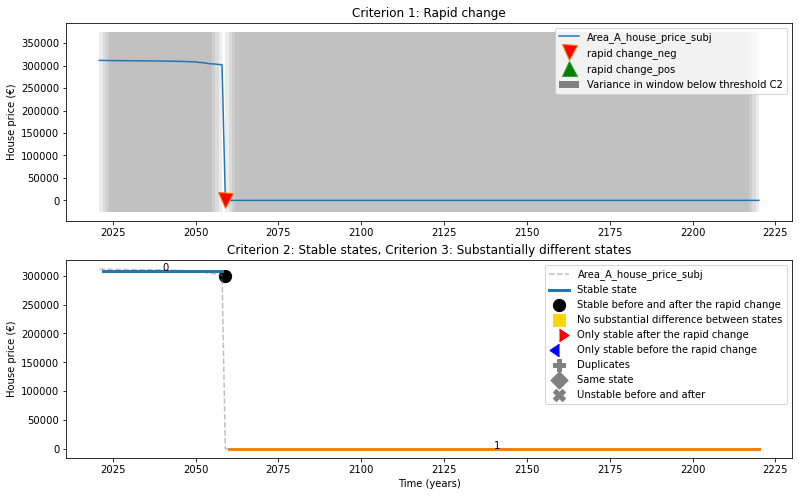

In [18]:
metric = M_sel[11]

metric.find_SETP_candidates(c1=c1,c2=c2,c3=c3, window=window,margin=margin)
print(metric.allSETPs_cands)
metric.select_SETPs(sign=-1)
print(metric.selected_SETPs)
fig, ax = metric.plot_SETPs(window=window,figsize=(13,8))

Here the algorithm works perfectly, but it also is a rather easy situation, of course.

D:\Python\Urban-SETP\tipping.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  perc_of_B = abs(100 * difference / first_house_price_stateB)


[2054__-1__real__None_, 2064__-1__sw__None_]
[2054]


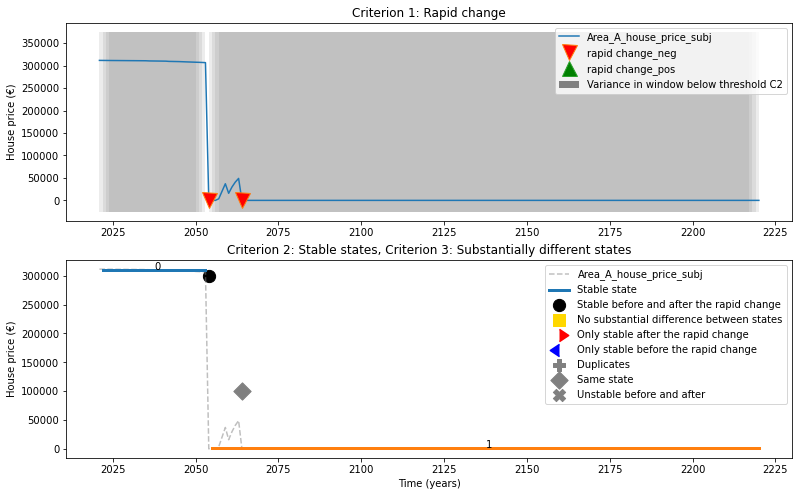

In [6]:
metric = M_sel[9]

metric.find_SETP_candidates(c1=c1,c2=c2,c3=c3, window=window,margin=margin)
print(metric.allSETPs_cands)
metric.select_SETPs(sign=-1)
print(metric.selected_SETPs)
fig, ax = metric.plot_SETPs(window=window,figsize=(13,8))

Hier detecteert hij ook netjes dat alleen de eerste situatie een shift van de ene naar de andere state is.

D:\Python\Urban-SETP\tipping.py:173: RuntimeWarning: invalid value encountered in double_scalars
  perc_of_A = abs(100 * difference / last_house_price_stateA)
D:\Python\Urban-SETP\tipping.py:174: RuntimeWarning: invalid value encountered in double_scalars
  perc_of_B = abs(100 * difference / first_house_price_stateB)
D:\Python\Urban-SETP\tipping.py:173: RuntimeWarning: divide by zero encountered in double_scalars
  perc_of_A = abs(100 * difference / last_house_price_stateA)


[2085__-1__ob__None_, 2086__-1__sw__dup_first -dups with: (2091, 2092), 2088__1__oa__None_, 2091__-1__sw__dup_, 2092__-1__sw__dup_, 2097__1__real__None_, 2100__-1__oa__dup_first -dups with: (2101), 2101__-1__oa__dup_, 2112__1__real__None_, 2127__1__oa__None_, 2152__1__real__None_, 2164__1__sw__None_, 2182__-1__oa__dup_first -dups with: (2185), 2185__1__oa__dup_, 2197__1__sw__None_]
[]


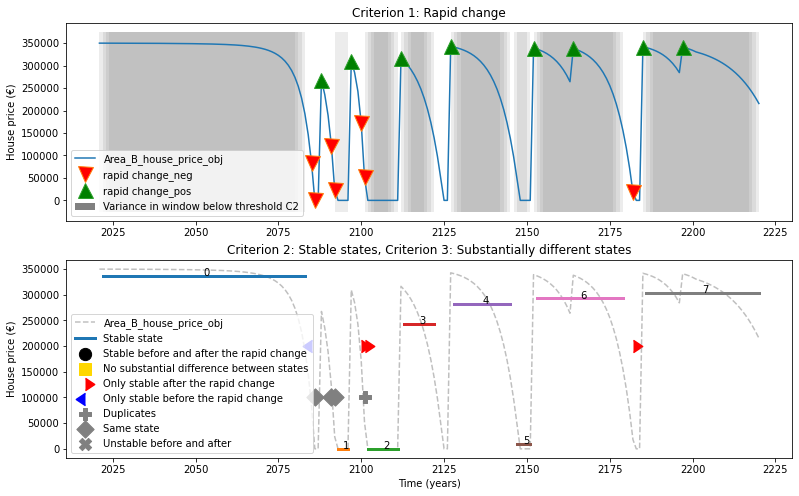

In [7]:
metric = M_sel[7]

metric.find_SETP_candidates(c1=c1,c2=c2,c3=c3, window=window,margin=margin)
print(metric.allSETPs_cands)
metric.select_SETPs(sign=-1)
print(metric.selected_SETPs)
fig, ax = metric.plot_SETPs(window=window,figsize=(13,8))

In deze situatie ziet hij geen enkel echt tipping point. Hij ziet wel een aantal situaties met een stabiele situatie voor **of** na de rapid change, maar geen situatie met stabiliteit voor **en** na de rapid change.

[2092__1__sw__dup_first -dups with: (2191), 2191__1__sw__dup_]
[]


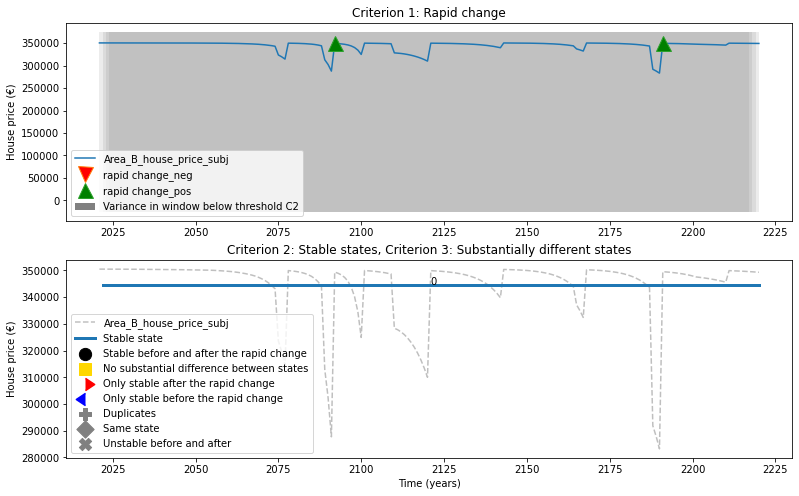

In [8]:
metric = M_sel[6]

metric.find_SETP_candidates(c1=c1,c2=c2,c3=c3, window=window,margin=margin)
print(metric.allSETPs_cands)
metric.select_SETPs(sign=-1)
print(metric.selected_SETPs)
fig, ax = metric.plot_SETPs(window=window,figsize=(13,8))

Hier zitten helemaal geen tipping points in. Wel 2x rapid change, maar alles is dezelfde state.

D:\Python\Urban-SETP\tipping.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  perc_of_B = abs(100 * difference / first_house_price_stateB)


[2028__-1__real__None_, 2056__-1__real__None_]
[2028, 2056]


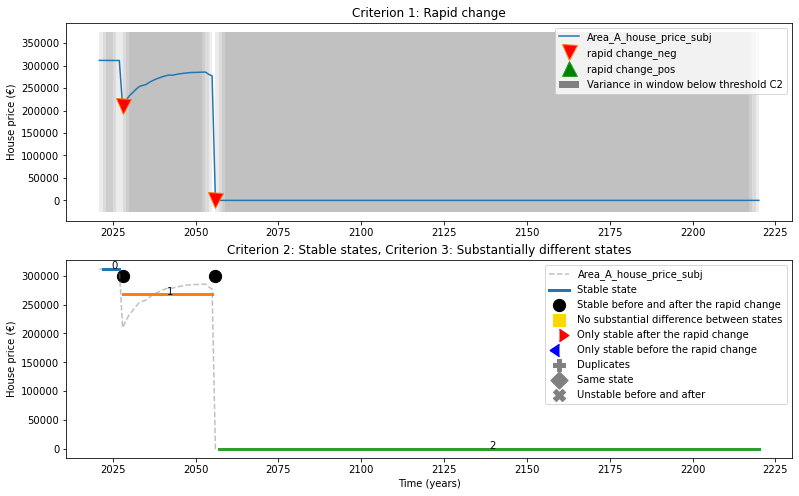

In [9]:
metric = M_sel[5]

metric.find_SETP_candidates(c1=c1,c2=c2,c3=c3, window=window,margin=margin)
print(metric.allSETPs_cands)
metric.select_SETPs(sign=-1)
print(metric.selected_SETPs)
fig, ax = metric.plot_SETPs(window=window,figsize=(13,8))

#CREATE SUBFOLDER IN VISUALISATION WITH CURRENT DATE
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
target = Path('Visualisations',date)
if not Path.exists(target): target.mkdir()
else: print("Target folder {} already exists".format(target))
    
filename = 'M5_old'

fig.savefig(Path(target, (filename + ".png")),bbox_inches='tight',dpi=150)

Hier twee hele duidelijke tipping points.

D:\Python\Urban-SETP\tipping.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  perc_of_B = abs(100 * difference / first_house_price_stateB)
D:\Python\Urban-SETP\tipping.py:173: RuntimeWarning: invalid value encountered in double_scalars
  perc_of_A = abs(100 * difference / last_house_price_stateA)
D:\Python\Urban-SETP\tipping.py:174: RuntimeWarning: invalid value encountered in double_scalars
  perc_of_B = abs(100 * difference / first_house_price_stateB)
D:\Python\Urban-SETP\tipping.py:173: RuntimeWarning: divide by zero encountered in double_scalars
  perc_of_A = abs(100 * difference / last_house_price_stateA)


[2081__-1__real__None_, 2086__-1__oa__dup_first -dups with: (2087), 2087__-1__oa__dup_, 2094__1__real__None_, 2096__-1__oa__None_, 2105__1__real__None_, 2108__-1__oa__None_, 2119__1__real__None_, 2131__-1__real__None_, 2133__1__oa__dup_first -dups with: (2134, 2135), 2134__-1__oa__dup_, 2135__-1__oa__dup_, 2154__1__real__dup_first -dups with: (2155), 2155__-1__real__dup_, 2169__1__real__None_, 2188__-1__real__None_, 2199__1__real__None_, 2216__-1__ob__dup_first -dups with: (2217), 2217__1__ob__dup_, 2218__-1__sw__None_]
[2081, 2131, 2188, 2155]


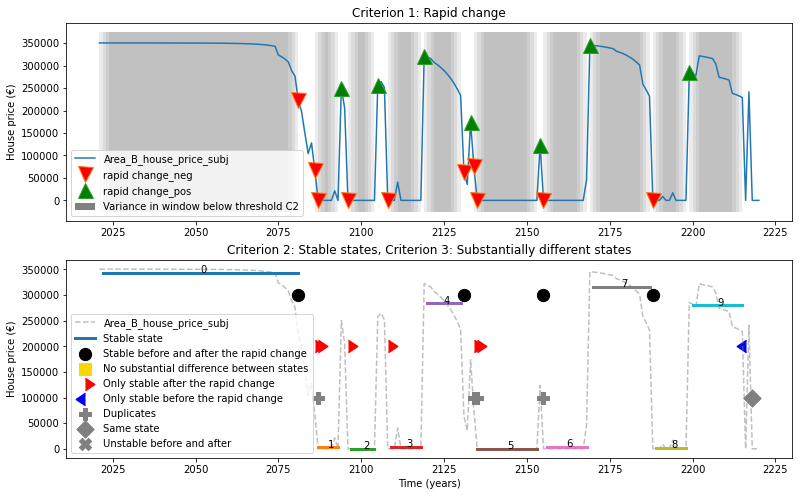

In [10]:
metric = M_sel[4]

metric.find_SETP_candidates(c1=c1,c2=c2,c3=c3, window=window,margin=margin)
print(metric.allSETPs_cands)
metric.select_SETPs(sign=-1)
print(metric.selected_SETPs)
fig, ax = metric.plot_SETPs(window=window,figsize=(13,8))

Dit gaat al best wel goed maar nog niet helemaal. De eerste is inderdaad duidelijk een tipping point. Maar de tweede en derde zijn in feite nog steeds dezelfde state shift, maar dat herkent hij niet.
Wat ook niet helemaal goed gaat: de eerste twee rode puntjes zijn zowel > maar ook +. Nu plot hij dat als beiden.

unsubstantial!!!!
[2076__-1__us__None_, 2079__1__oa__None_, 2121__-1__sw__dup_first -dups with: (2122), 2122__1__sw__dup_]
[]


(<Figure size 936x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DA50FE2340>,
       dtype=object))

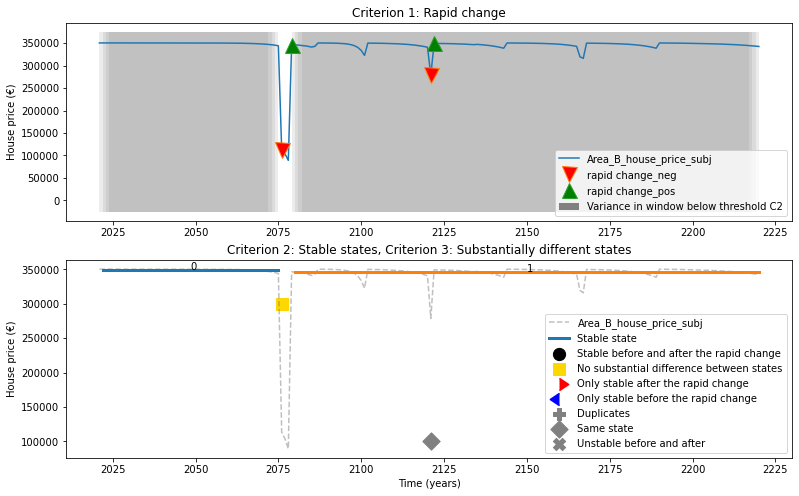

In [11]:
metric = M_sel[3]

metric.find_SETP_candidates(c1=c1,c2=c2,c3=c3, window=window,margin=margin)
print(metric.allSETPs_cands)
metric.select_SETPs(sign=-1)
print(metric.selected_SETPs)
fig, ax = metric.plot_SETPs(window=window,figsize=(13,8))

Dit is weer helemaal goed; maar hij test inderdaad nog niet op criterum 3!

[]
[]


(<Figure size 936x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DA517D4100>,
       dtype=object))

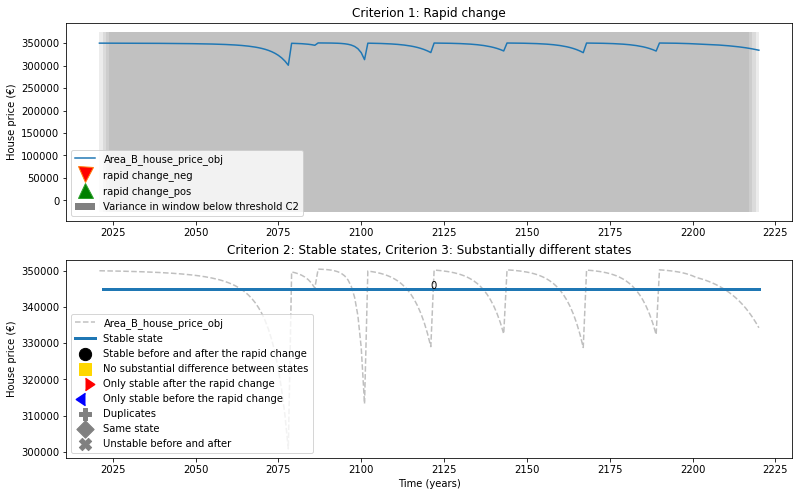

In [12]:
metric = M_sel[2]

metric.find_SETP_candidates(c1=c1,c2=c2,c3=c3, window=window,margin=margin)
print(metric.allSETPs_cands)
metric.select_SETPs(sign=-1)
print(metric.selected_SETPs)
fig, ax = metric.plot_SETPs(window=window,figsize=(13,8))

Dit ook

[2076__-1__real__None_, 2084__1__real__dup_first -dups with: (2085, 2087), 2085__-1__real__dup_, 2087__1__real__dup_, 2092__1__real__dup_first -dups with: (2096, 2097), 2096__-1__real__dup_, 2097__-1__real__dup_, 2111__1__sw__None_, 2112__-1__ob__dup_first -dups with: (2118), 2118__1__ob__dup_, 2123__-1__real__None_, 2127__1__oa__None_, 2150__-1__ob__dup_first -dups with: (2151), 2151__1__ob__dup_, 2154__-1__oa__dup_first -dups with: (2156, 2157, 2158), 2156__1__oa__dup_, 2157__-1__oa__dup_, 2158__1__oa__dup_, 2166__-1__real__None_, 2177__1__real__None_, 2189__-1__real__None_, 2191__1__sw__dup_first -dups with: (2192), 2192__-1__sw__dup_, 2197__1__real__None_, 2199__-1__oa__None_, 2212__1__real__None_]
[2076, 2123, 2166, 2189, 2085, 2096]


D:\Python\Urban-SETP\tipping.py:173: RuntimeWarning: divide by zero encountered in double_scalars
  perc_of_A = abs(100 * difference / last_house_price_stateA)
D:\Python\Urban-SETP\tipping.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  perc_of_B = abs(100 * difference / first_house_price_stateB)


(<Figure size 936x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DA501734C0>,
       dtype=object))

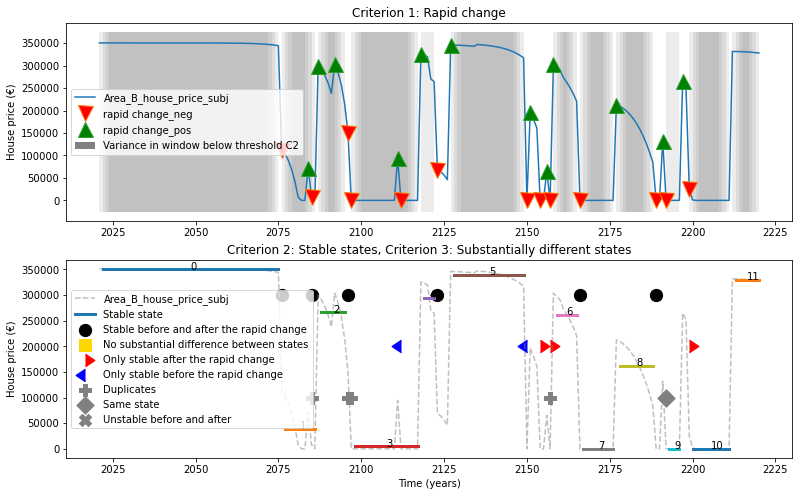

In [14]:
metric = M_sel[0]

metric.find_SETP_candidates(c1=c1,c2=c2,c3=c3, window=window,margin=margin)
print(metric.allSETPs_cands)
metric.select_SETPs(sign=-1)
print(metric.selected_SETPs)
fig, ax = metric.plot_SETPs(window=window,figsize=(13,8))

Dit zijn de complexe situaties... De eerste klopt sowieso, dat is eigenlijk het belangrijkst...

[2084__-1__real__None_, 2096__1__real__dup_first -dups with: (2097), 2097__-1__real__dup_, 2121__1__real__None_, 2128__-1__real__None_, 2137__1__real__None_, 2154__-1__ob__None_, 2157__1__oa__dup_first -dups with: (2158, 2162), 2158__-1__oa__dup_, 2162__1__oa__dup_, 2177__-1__real__None_, 2179__1__oa__dup_first -dups with: (2180), 2180__-1__oa__dup_, 2188__1__ob__None_, 2194__-1__real__dup_first -dups with: (2195), 2195__-1__real__dup_, 2202__1__real__None_, 2213__-1__real__None_]
[2084, 2128, 2177, 2194, 2213, 2097]


D:\Python\Urban-SETP\tipping.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  perc_of_B = abs(100 * difference / first_house_price_stateB)
D:\Python\Urban-SETP\tipping.py:173: RuntimeWarning: invalid value encountered in double_scalars
  perc_of_A = abs(100 * difference / last_house_price_stateA)
D:\Python\Urban-SETP\tipping.py:174: RuntimeWarning: invalid value encountered in double_scalars
  perc_of_B = abs(100 * difference / first_house_price_stateB)
D:\Python\Urban-SETP\tipping.py:173: RuntimeWarning: divide by zero encountered in double_scalars
  perc_of_A = abs(100 * difference / last_house_price_stateA)


(<Figure size 936x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DA4F09C2B0>,
       dtype=object))

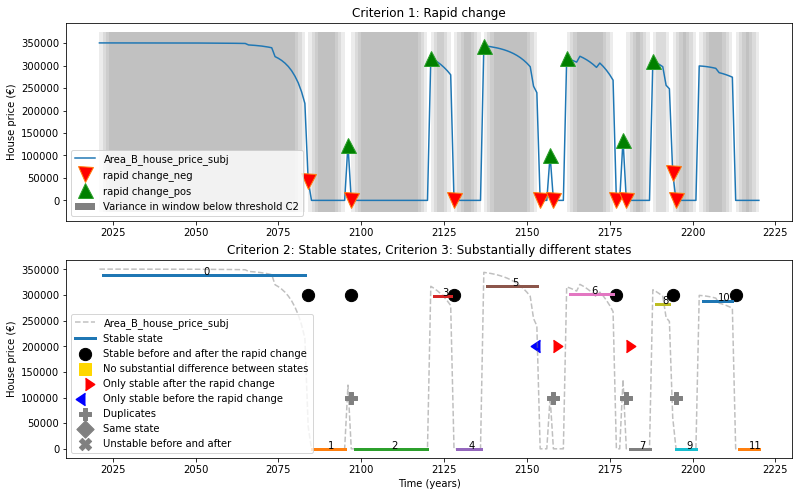

In [15]:
metric = M_sel[12]

metric.find_SETP_candidates(c1=c1,c2=c2,c3=c3, window=window,margin=margin)
print(metric.allSETPs_cands)
metric.select_SETPs(sign=-1)
print(metric.selected_SETPs)
fig, ax = metric.plot_SETPs(window=window,figsize=(13,8))

Hier gaat het ook goed.

[2042__-1__real__None_, 2066__-1__real__None_]
[2042, 2066]


D:\Python\Urban-SETP\tipping.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  perc_of_B = abs(100 * difference / first_house_price_stateB)


(<Figure size 936x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DA4EF51700>,
       dtype=object))

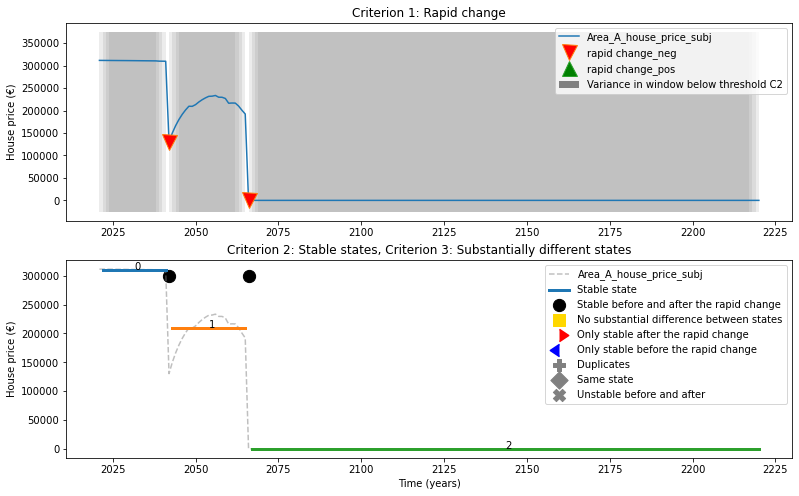

In [16]:
metric = M_sel[13]

metric.find_SETP_candidates(c1=c1,c2=c2,c3=c3, window=window,margin=margin)
print(metric.allSETPs_cands)
metric.select_SETPs(sign=-1)
print(metric.selected_SETPs)
fig, ax = metric.plot_SETPs(window=window,figsize=(13,8))

Dit is ook heel netjes.

[2050__-1__real__None_, 2060__-1__real__None_]
[2050, 2060]


D:\Python\Urban-SETP\tipping.py:173: RuntimeWarning: invalid value encountered in double_scalars
  perc_of_A = abs(100 * difference / last_house_price_stateA)
D:\Python\Urban-SETP\tipping.py:174: RuntimeWarning: invalid value encountered in double_scalars
  perc_of_B = abs(100 * difference / first_house_price_stateB)


(<Figure size 936x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DA4FB1E7F0>,
       dtype=object))

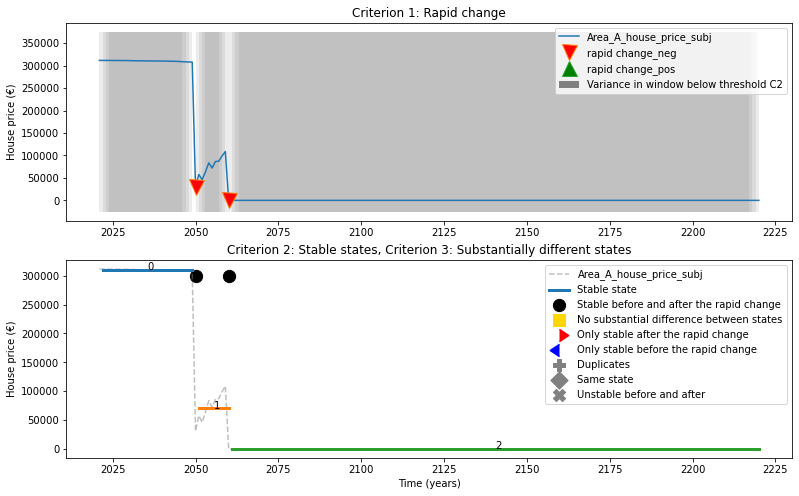

In [17]:
metric = M_sel[15]

metric.find_SETP_candidates(c1=c1,c2=c2,c3=c3, window=window,margin=margin)
print(metric.allSETPs_cands)
metric.select_SETPs(sign=-1)
print(metric.selected_SETPs)
fig, ax = metric.plot_SETPs(window=window,figsize=(13,8))